In [317]:
import numpy as np
import sympy as smp
from centrex_tlf_hamiltonian import states, hamiltonian
import centrex_tlf_couplings as couplings
import centrex_TlF_lindblad as lindblad
import matplotlib.pyplot as plt
import scipy.constants as cst
from labellines import labelLines
import pickle
import datetime
import pandas as pd
import statsmodels.api as sm

In [318]:
plt.rcParams.update({'font.size': 14})

# Setup

## Papermill Parameters

In [319]:
# this cell is tagged parameters
# transition label : 'couplings.OpticalTransition(couplings.OpticalTransitionType.Q/R/..., J_ground, F1_excited, F_excited)'

#transition = 'couplings.OpticalTransition(couplings.OpticalTransitionType.R, 1, F1=1.5, F=2)'
transition = 'couplings.transition.OpticalTransition(couplings.transition.OpticalTransitionType.R, 1, F1=3/2, F=1)'
#transition = 'couplings.transition.OpticalTransition(couplings.transition.OpticalTransitionType.Q, 1, F1=1/2, F=1)'

# polarizations = "[couplings.polarization_Z, couplings.polarization_X]"
#only consider σp polarization light
#polarizations = "[couplings.polarization_Z]"
polarizations = "[couplings.polarization_σp, couplings.polarization_σm]"
# polarizations = "[couplings.polarization_σp]"

powers = np.linspace(1-2e-3,1+2e-3,4)
forward_velocities = np.arange(90, 300+4, 4)
transverse_velocities = np.arange(-4.5, 4.5+0.2, 0.2)

ωp = 0.1*hamiltonian.Γ
ωphase = hamiltonian.Γ
β = 3.8
ωl = 2*np.pi*100e3

dx = 2.54e-2 # dx of laser beam
dy = 2*2.54e-2 # dy of laser beam

initial_state = '''states.QuantumSelector(
    J=1, F1=3/2, F=1, mF=1, electronic=states.ElectronicState.X
)'''

nprocs = 7 # number of processes to use

μvy = 0
σvy = 1.5

now = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')

In [320]:
# use eval to transfer the Transitions, QuantumSelectors and numpy arrays
transition = eval(transition)
polarizations = eval(polarizations)
powers = np.asarray(powers)
forward_velocities = np.asarray(forward_velocities)
transverse_velocities = np.asarray(transverse_velocities)
initial_state = eval(initial_state)

## Functions to convert Power to Rabi and vice-versa

In [321]:
def power_from_rabi_rectangle(Ω: complex, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> float:
    E = Ω*cst.hbar / (main_coupling * D)
    intensity = 1/2 * cst.c * cst.epsilon_0 * E ** 2
    P = intensity * (dx * dy)
    return P.real

def rabi_from_power_rectangle(power: float, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> complex:
    intensity = power / (dx * dy)
    E = np.sqrt(intensity*2 / (cst.c * cst.epsilon_0))
    Ω = E * main_coupling * D / cst.hbar
    return Ω

## Functions to convert transverse velocity to detuning

In [322]:
def doppler_shift(velocity, frequency):
    """calculate the doppler shifted frequency
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
    Returns:
        float: doppler shifted frequency in Hz
    """
    return frequency * (1 + velocity / cst.c)


def velocity_to_detuning(velocity, frequency=1.103e15, Γ=2*np.pi*1.56e6):
    """convert velocity to detuning in units of Γ
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
        Γ (float): Γ [2π⋅Hz]
    Returns:
        float: detuning in units of Γ
    """
    return (doppler_shift(velocity, frequency) - frequency) * 2 * np.pi / Γ

## Function to convert diagonal indices to flattened

In [323]:
def get_diagonal_indices_flattened(size, states = None, mode = 'python'):
    if states is None:
        indices = [i+size*i for i in range(size)]
    else:
        indices = [i+size*i for i in states]
    if mode == 'julia':
        return [i+1 for i in indices]
    elif mode == 'python':
        return indices

## System Parameters

In [324]:
syspars = lindblad.SystemParameters(nprocs = nprocs, Γ=hamiltonian.Γ)

## Vibrational Decay Channels

In [325]:
decay_channels = [
    lindblad.DecayChannel(
        ground = 1*states.CoupledBasisState(None, None, None, None, None, None, v = "other",P=+1),
        excited = transition.qn_select_excited,
        branching = 1e-2,
        description = "vibrational decay"
    )
]

## Odepars

In [326]:
v_to_Γ = velocity_to_detuning(1)*syspars.Γ

odepars = lindblad.odeParameters(
    Ω0 = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δ0      = f"vy*{v_to_Γ}",              # detuning of the laser [rad/s]

    #laser polarization switching
    ωp = ωp,           # polarization switching frequency [rad/s]
    Pσp0 = "square_wave(t, ωp, 0.)",
    Pσm0 = f"square_wave(t, ωp, {np.pi})",
    β = β,
    ωphase = ωphase,
    ωl = ωl,
    
    # # laser without polarization switching
    # Pσp0 = 1,
    # β = β,
    # ωphase = ωphase,
    # ωl = ωl,

    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

In [327]:
1*syspars.Γ
Ωl0     = 2387702,

## Generate the System

In [328]:

# transition_selectors = couplings.generate_transition_selectors([transition], [polarizations], ground_mains = [1*states.CoupledBasisState(F=1, mF=1, F1 = 1/2, J = 1, I1 = 1/2, I2 = 1/2, Omega = 0, P = -1,electronic_state= states.ElectronicState.X)],
# excited_mains = [1*states.CoupledBasisState(F=1, mF=-1, F1 = 1/2, J = 1, I1 = 1/2, I2 = 1/2, Omega = 1, P = 1, electronic_state= states.ElectronicState.B)])
#transition_selectors = couplings.generate_transition_selectors([transition], [polarizations])
transition_selectors = couplings.generate_transition_selectors([transition], [polarizations], ground_mains = [1*states.CoupledBasisState(F=1, mF=0, F1 = 1/2, J = 1, I1 = 1/2, I2 = 1/2, Omega = 0, P = -1,electronic_state= states.ElectronicState.X)],
excited_mains = [1*states.CoupledBasisState(F=1, mF=1, F1 = 3/2, J = 2, I1 = 1/2, I2 = 1/2, Omega = 1, P = 1, electronic_state= states.ElectronicState.B)])

In [329]:
transition_selectors[0].excited_main

1.00 x |B, J = 2, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 1>

In [330]:
# obe_system = lindblad.setup_OBE_system_julia_transitions(
#     odepars, [transition], transition_selectors, verbose=True, full_output=True,
#     decay_channels = decay_channels, E=np.array([0,0,200])
# )
obe_system = lindblad.setup_OBE_system_julia_transitions(
    odepars, [transition], transition_selectors, verbose=True, full_output=True,
    decay_channels = decay_channels, E=np.array([0,0,100]), n_procs = nprocs, qn_compact = True
)

INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 7 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 7 processes


In [331]:
obe_system.QN[1]

0.87-0.00j x |X, J = 1, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
0.50-0.00j x |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
0.00-0.00j x |X, J = 2, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>
0.00-0.00j x |X, J = 2, F₁ = 5/2, F = 3, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>

In [332]:
np.diag(obe_system.H_symbolic)/(2*np.pi*1e6)

array([-1.13247203626594, 1.59154943091895e-7*δ0 + 0.00031256130269988,
       1.59154943091895e-7*δ0 + 0.023116954066939, 1.59154943091895e-7*δ0,
       1.59154943091895e-7*δ0 + 0.0231169379076222,
       1.59154943091895e-7*δ0 + 0.13973587049461,
       1.59154943091895e-7*δ0 + 1.11674437633592,
       1.59154943091895e-7*δ0 + 0.139735884885971,
       1.59154943091895e-7*δ0 + 0.151280334952401,
       1.59154943091895e-7*δ0 + 1.10517204148125,
       1.59154943091895e-7*δ0 + 1.1087315612456,
       1.59154943091895e-7*δ0 + 1.10517197694113,
       1.59154943091895e-7*δ0 + 0.151280269363157, 40003.9851001374,
       80008.1319912663, 0, 1.16388269125913e-5, -42.3762810222721, 0],
      dtype=object)

## Calculate Rabi rate for 1 W

In [333]:
rabi_1W = rabi_from_power_rectangle(0.5, np.abs(obe_system.couplings[0].main_coupling), dx, dy)
print(rabi_1W)

2063142.2430441547


# Single trajectory run

OpticalTransition(R(1) F1'=3/2 F'=1) => 0.01 photons


,"|B, J = 2, F₁ = 3/2, F = 1>"
states,
"|X, J = 0>",0.051125
"|X, J = 1>",0.507004
"|X, J = 2>",0.234024
"|X, J = 3>",0.207847


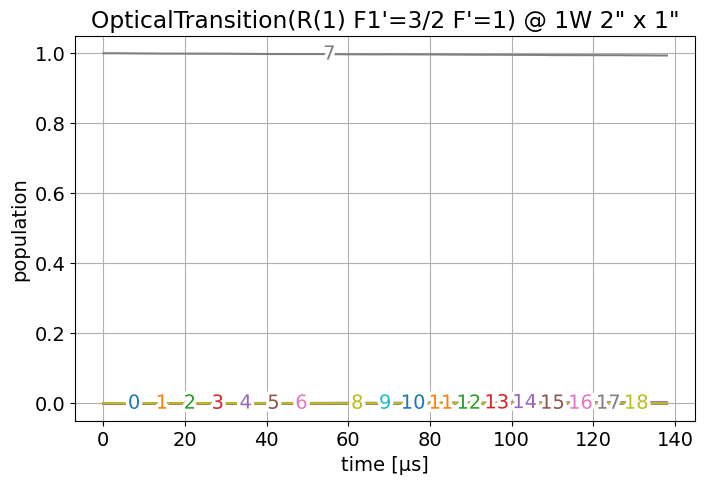

In [334]:
indices_excited = transition.qn_select_excited.get_indices(obe_system.QN)

ρ = states.population.generate_population_states(
    initial_state.get_indices(obe_system.QN), 
    len(obe_system.QN)
)

df = couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground='J')

odepars.Ωl0 = rabi_1W

problem = lindblad.OBEProblem(
    odepars,ρ, (0.0,dx/odepars.vz)
    )

result_single = lindblad.do_simulation_single(problem)

fig, ax = plt.subplots(figsize = (8,5)) 
ax.plot(result_single.t*1e6, result_single.y.T, label = np.arange(len(result_single.y)));
ax.set_xlabel('time [μs]')
ax.set_ylabel('population')

ax.set_title(f'{transition} @ 1W 2" x 1"')

labelLines(ax.get_lines(), zorder = 2.5, align = False, fontsize = 14)

ax.grid(True)

print(f"{transition} => {np.trapz(result_single.y[indices_excited].sum(axis=0), x=result_single.t)*hamiltonian.Γ:.2f} photons")
display(df)